# Import Packages

In [1]:
import pickle
import re
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from nltk.corpus import stopwords
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import plotly.express as px
import plotly.graph_objects as go
import tomotopy as tp
import pyLDAvis
import tmplot
import nltk
from tqdm import tqdm
from gensim.models.phrases import Phrases

2023-08-14 12:52:08.555835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [24]:
df = pd.read_csv("/Users/irene/CloudStation/Courses/ARP/ARP code/Maserati-ARP/Maserati-ARP/Dataset/germancarforum_cleaned_NLP_final_v1.csv", low_memory=False)

# Prepare data

In [25]:
df1 = df.copy()

In [26]:
df2 = df1[df1["section_name"].isin(['Ferrari', 'Aston Martin', 'Porsche', 'BMW', 
                                                  'Alfa Romeo', 'Mercedes-Benz', 'Maserati'])]

In [19]:
df_size = df2.groupby(["section_name"]).size()
df_size = df_size.sort_values(ascending=False)

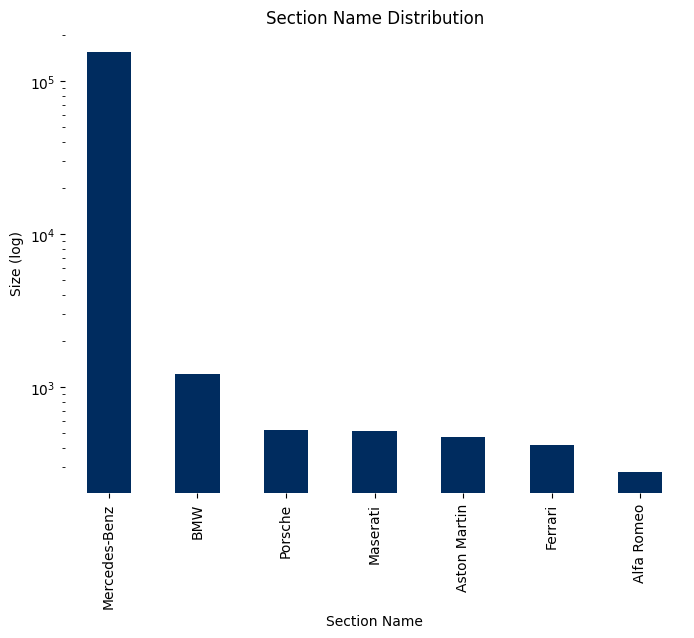

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
df_size.plot(kind = "bar", ax = ax, color="#002C5F")
ax.set_xlabel("Section Name")
ax.set_ylabel("Size (log)")
ax.set_yscale('log')
ax.set_title("Section Name Distribution")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks(fontsize=10)
plt.show()

# NLP pineline

In [27]:
df3 = df2.dropna(subset="post_text")

In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146025 entries, 0 to 198501
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           146025 non-null  int64  
 1   section_name         146025 non-null  object 
 2   thread_title         146025 non-null  object 
 3   post_ID              146025 non-null  int64  
 4   post_date            146025 non-null  object 
 5   post_username        144168 non-null  object 
 6   post_text            146025 non-null  object 
 7   post_order           146025 non-null  int64  
 8   replier_post_ID      43053 non-null   object 
 9   user_location        383 non-null     object 
 10  user_gender          282 non-null     object 
 11  user_occupation      137 non-null     object 
 12  user_messages_count  1101 non-null    float64
 13  user_reaction_score  1101 non-null    float64
 14  user_car             225 non-null     object 
 15  user_birthday        4

In [29]:
docs = df3["post_text"]

In [12]:
nlp = spacy.load("en_core_web_lg")

In [13]:
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

In [30]:
tkns_docs = [preprocess(text) for text in tqdm(docs)]

  0%|          | 0/146025 [00:00<?, ?it/s]

100%|██████████| 146025/146025 [44:50<00:00, 54.27it/s] 


In [31]:
# save the list of tokens
with open('germancar_TP_tkns.pkl', 'wb') as f:
    pickle.dump(tkns_docs, f)

In [3]:
# load tokens
with open('germancar_TP_tkns.pkl', 'rb') as f:
    docs_tokens_loaded = pickle.load(f)

In [4]:
# find bigrams and trigrams

# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    u"be",
    u"to",
    u"this",
    u"who",
    u"in",
]
# find phrases
bigram = Phrases( # capturing bi-grams
    docs_tokens_loaded,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases( # capturing tri-grams
    bigram[docs_tokens_loaded],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)

# uncomment if bi-grammed, tokenized document is preferred

# docs_phrased = [bigram[line] for line in docs_tokens]
docs_phrased_all = [trigram[bigram[line]] for line in docs_tokens_loaded] # tokenized documents and join 
                                                                # the tokens associated with 
                                                                # bi- or tri-grams.

# TP (gensim)

In [5]:
# test = docs_phrased_all[:50]
test = docs_phrased_all

In [6]:
import gensim.corpora as corpora
gensim_dictionary = corpora.Dictionary(test)

In [14]:
len(test)

146025

In [7]:
# doc2bow
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in test]

100%|██████████| 40/40 [25:06:25<00:00, 2259.63s/it]   


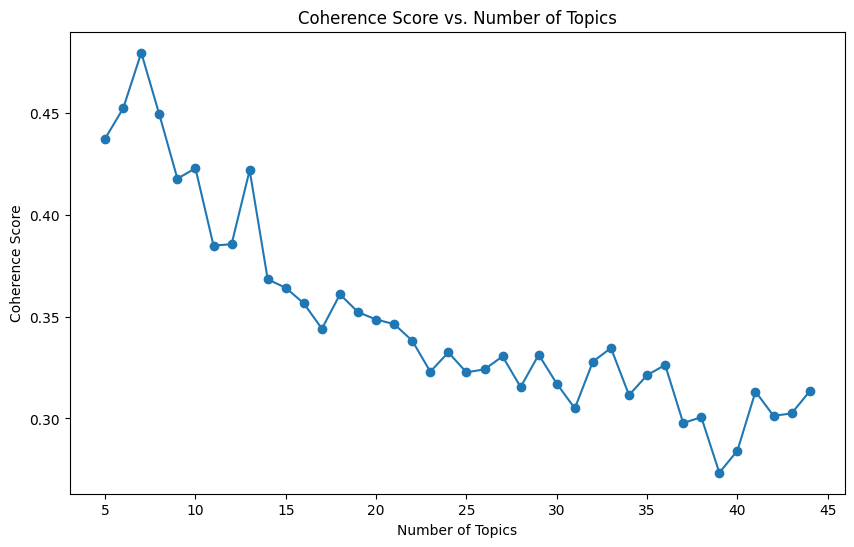

In [78]:
coherence_scores = []
num_topics_range = range(5, 20)

for num_topics in tqdm(num_topics_range):
    # Creating the LDA model
    lda_model = LdaModel(
        corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=num_topics,
        random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto',
        per_word_topics=True
    )

    # Calculating and storing the coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=test, dictionary=gensim_dictionary, coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()


    coherence_scores.append(coherence_lda)

# Plotting the coherence scores against the number of topics
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.grid(False)
plt.show()

In [8]:
#creating the LDA model 
lda_model = LdaModel(corpus=gensim_corpus, id2word=gensim_dictionary, 
                     num_topics=7, random_state=100, 
                     update_every=1, chunksize=100, passes=10, 
                     alpha='auto', per_word_topics=True
)

In [9]:
#calculating and displaying the coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=test, 
                                     dictionary=gensim_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4795745231669442


In [11]:
document_topics = []

for doc in test:
    doc_bow = gensim_dictionary.doc2bow(doc)
    topic_distribution = lda_model.get_document_topics(doc_bow)
    most_probable_topic = max(topic_distribution, key=lambda item: item[1])
    topic_number = most_probable_topic[0]
    document_topics.append((doc, topic_number))

df = pd.DataFrame(document_topics, columns=["content", "topic number"])


In [12]:
df["topic number"].unique()

array([5, 1, 2, 3, 6, 4, 0])

In [13]:
df1 = df["topic number"]

In [14]:
t1 = pd.DataFrame({'tokens': [' '.join(sublist) for sublist in test]})

In [15]:
d1 = [t1,df1]
t2 = pd.concat(d1, axis=1)

In [30]:
output = df3[["post_text"]]

In [38]:
output

,post_text
0,",,"
2,Rather like the 911 which has far outlasted th...
7,Found this on another board hope it's ok to po...
11,Correct analysis. The only difference of opini...
14,"Look at how beautiful this damn car is!,That b..."
...,...
198497,+1 Agreed. A boxster I just sold was delivered...
198498,Manon is arriving on 10/12 now. 2 days ahead s...
198499,saw another CLA today this time a mountain gre...
198500,dont want to tow...just attach the bike carrie...


In [81]:
import pyLDAvis.gensim_models as gensimvis

# Enable the Jupyter notebook display for pyLDAvis
pyLDAvis.enable_notebook()

# Creating the pyLDAvis visualization
vis = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary)

# Display the pyLDAvis visualization
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.310738  0.079227       1        1  25.290165
2      0.017713 -0.269725       2        1  21.697838
1      0.255308  0.081110       3        1  14.342600
4     -0.089022 -0.254026       4        1  10.978948
6     -0.180848  0.285576       5        1  10.646405
3     -0.103484  0.045458       6        1   9.388253
0     -0.210405  0.032381       7        1   7.655792, topic_info=          Term          Freq         Total Category  logprob  loglift
560   mercedes  40540.000000  40540.000000  Default  30.0000  30.0000
136      class  40754.000000  40754.000000  Default  29.0000  29.0000
63        look  39869.000000  39869.000000  Default  28.0000  28.0000
0          car  53822.000000  53822.000000  Default  27.0000  27.0000
153        new  34793.000000  34793.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
464      wheel   4231.697793  12667.303206   Topic7  -4.1799   1.4733
411       high   2813.754564   9648.810409   Topic7  -4.5880   1.3374
567      sport   2439.208008   7600.074888   Topic7  -4.7308   1.4332
1011   leather   1851.952671   3292.016342   Topic7  -5.0062   1.9944
153        new   3423.036187  34793.342307   Topic7  -4.3920   0.2508

[294 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1254      3  0.999620      able
1243      7  0.999534    active
281       2  0.999821  actually
323       6  0.999723     agree
465       6  0.999724       air
...     ...       ...       ...
107       4  0.999725     world
1547      5  0.999342      yeah
131       2  0.833046      year
131       4  0.166917      year
1390      5  0.999862       yes

[312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 5, 7, 4, 1])

# Load Data

In [ ]:
df = pd.read_csv("/Users/irene/CloudStation/Courses/ARP/ARP code/Maserati-ARP/Maserati-ARP/Data-analysis/sportmaserati_EU.csv")

In [ ]:
df

,Comment,europe
0,wonder necessary handle power super car day ri...,0
1,mid late japanese motorbike industry create vo...,0
2,oh v max blow limit couple year later think st...,1
3,guy sound like constant job interview mid gear...,1
4,enjoy watch throttle house,1
...,...,...
391603,not find bad think twice junction honest round...,1
391604,drive abroad usually drive continent time year...,1
391605,accident happen junction look right instead le...,0
391606,having spend year driving life work iran yearl...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391608 entries, 0 to 391607
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Comment  386923 non-null  object
 1   europe   391608 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ MB


In [ ]:
sptest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391608 entries, 0 to 391607
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  391608 non-null  int64 
 1   Comment     391608 non-null  object
 2   tokens      386923 non-null  object
 3   europe      391608 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 12.0+ MB


In [ ]:
df1 = df.dropna()

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386923 entries, 0 to 391607
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Comment  386923 non-null  object
 1   europe   386923 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.9+ MB


In [ ]:
df1

,Comment,europe
0,wonder necessary handle power super car day ri...,0
1,mid late japanese motorbike industry create vo...,0
2,oh v max blow limit couple year later think st...,1
3,guy sound like constant job interview mid gear...,1
4,enjoy watch throttle house,1
...,...,...
391603,not find bad think twice junction honest round...,1
391604,drive abroad usually drive continent time year...,1
391605,accident happen junction look right instead le...,0
391606,having spend year driving life work iran yearl...,0


# Prepare data

In [ ]:
df2 = df1[df1["europe"]==1]

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284842 entries, 2 to 391607
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Comment  284842 non-null  object
 1   europe   284842 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ MB


In [ ]:
content = df2.Comment

In [ ]:
# filtered the data
def contains_word(strings, words):
    results = []
    for s in strings:
        results.append(any(word in s for word in words))
    return results

In [ ]:
brands = ['ferrari', 'aston martin', 'porsche', 'bmw', 'alfa romeo', 'maserati', 'maser']

In [ ]:
result = contains_word(content, brands)

In [ ]:
content_comp = [num for flag, num in zip(result, content) if flag]

In [ ]:
output = pd.DataFrame(content_comp, columns=['content'])

In [ ]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25790 entries, 0 to 25789
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  25790 non-null  object
dtypes: object(1)
memory usage: 201.6+ KB


In [ ]:
# test = docs_phrased_all[:50]
test = output["content"]

In [ ]:
test = [item.split(" ") for item in test]

In [ ]:
import gensim.corpora as corpora
gensim_dictionary = corpora.Dictionary(test)

In [ ]:
# doc2bow
gensim_corpus = [gensim_dictionary.doc2bow(text) for text in test]

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [14:52:52<00:00, 630.26s/it]   


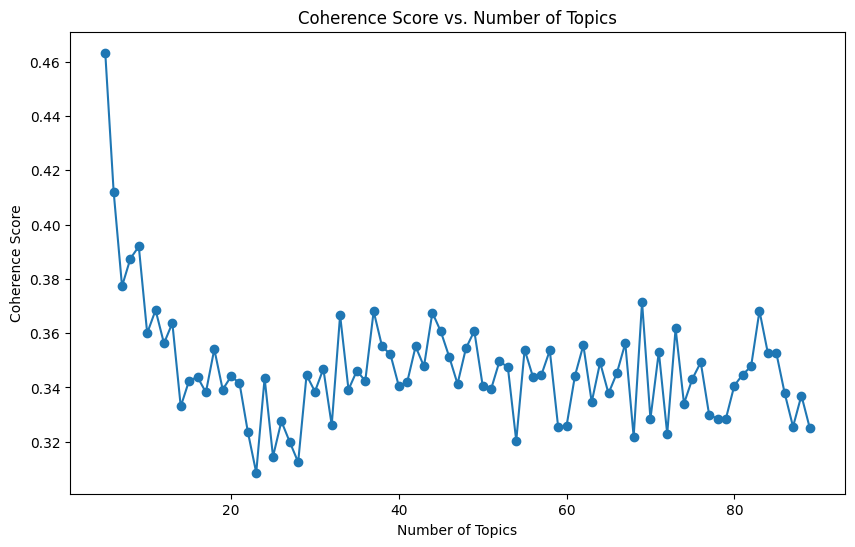

In [ ]:
coherence_scores = []
num_topics_range = range(5, 90)

for num_topics in tqdm(num_topics_range):
    # Creating the LDA model
    lda_model = LdaModel(
        corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=num_topics,
        random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto',
        per_word_topics=True
    )

    # Calculating and storing the coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=test, dictionary=gensim_dictionary, coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()


    coherence_scores.append(coherence_lda)

# Plotting the coherence scores against the number of topics
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score") 
plt.title("Coherence Score vs. Number of Topics")
plt.grid(False)
plt.show()

In [ ]:
#creating the LDA model 
lda_model = LdaModel(corpus=gensim_corpus, id2word=gensim_dictionary, 
                       num_topics=6, random_state=100, 
                     update_every=1, chunksize=100, passes=10, 
                     alpha='auto', per_word_topics=True
)

In [ ]:
#calculating and displaying the coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=test, 
                                     dictionary=gensim_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.41217598313164033


In [ ]:
import pyLDAvis.gensim_models as gensimvis

# Enable the Jupyter notebook display for pyLDAvis
pyLDAvis.enable_notebook()

# Creating the pyLDAvis visualization
vis = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary)

# Display the pyLDAvis visualization
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.320003  0.029591       1        1  49.902401
3     -0.238300  0.045276       2        1  19.398480
5      0.080018 -0.368638       3        1  11.367402
4      0.132387  0.048835       4        1   8.430158
2      0.156688  0.093886       5        1   6.925684
1      0.189211  0.151050       6        1   3.975875, topic_info=          Term          Freq         Total Category  logprob  loglift
2     maserati  26057.000000  26057.000000  Default  30.0000  30.0000
15         car  17058.000000  17058.000000  Default  29.0000  29.0000
283     engine   2421.000000   2421.000000  Default  28.0000  28.0000
383      forum   4725.000000   4725.000000  Default  27.0000  27.0000
394     member   2226.000000   2226.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1080        hp    224.413657    225.678735   Topic6  -5.0761   3.2193
441       pump    212.405868    213.665912   Topic6  -5.1311   3.2190
2989       jag    203.114725    204.374849   Topic6  -5.1758   3.2187
5286      mail    201.968837    203.244618   Topic6  -5.1814   3.2186
907     centre    194.504736    195.768670   Topic6  -5.2191   3.2184

[252 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
835       4  0.998570         add
171       1  0.999197        alfa
13        6  0.994162     article
272       2  0.998654         ask
1499      6  0.994413  automotive
...     ...       ...         ...
411       2  0.999522        work
121       1  0.966030        year
121       2  0.033756        year
237       5  0.997322      yellow
254       5  0.999054         yep

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 6, 5, 3, 2])

# Load Data

In [ ]:
df = pd.read_csv("/Users/irene/Downloads/ML_EU_with_comp.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5201 entries, 0 to 5200
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  5201 non-null   object
dtypes: object(1)
memory usage: 40.8+ KB


In [ ]:
docs = (df['content']).to_list() #Convert content rows to list

In [ ]:
len(docs)

5201

# PreProcessing:

In [ ]:
#python3 -m spacy download en:
nlp = spacy.load("en_core_web_lg")

In [ ]:
#Tokenize and remove punct:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  #deacc=True removes punctuations
data_words = list(sent_to_words(docs))

In [ ]:
#Build Bigram:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=80) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
#Define function for stopwords, bigrams,and lemmatization:
stop_words = stopwords.words('english')
stop_words.extend(['also', 'get', 'got','much'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
#Remove Stop Words:
data_words_nostops = remove_stopwords(data_words)

#Form Bigrams:
data_words_bigrams = make_bigrams(data_words_nostops)

#Lemmatization keeping only noun, adj, vb, adv:
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[2500])

['recently', 'think', 'test', 'think', 'write', 'develop', 'market', 'fast', 'forward', 'good', 'corner', 'follow', 'magazine', 'qp', 'well', 'aspect', 'time', 'surprisingly', 'comfortable']


In [ ]:
#Create Dictionary: 
id2word = corpora.Dictionary(data_lemmatized)  
#Create Corpus: 
texts = data_lemmatized  
#Term Document Frequency: 
corpus = [id2word.doc2bow(text) for text in texts]  

#print(corpus)

# GENSIM LDA

In [ ]:
#For Loop on Num Topics:
coherence_values = []
model_list = []

for num_topics in range(15, 110,5):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,
                                           num_topics= num_topics,
                                           random_state=0,
                                           update_every=1,
                                           chunksize=700,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model= model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherence_model_lda.get_coherence())
    model_list.append(model)

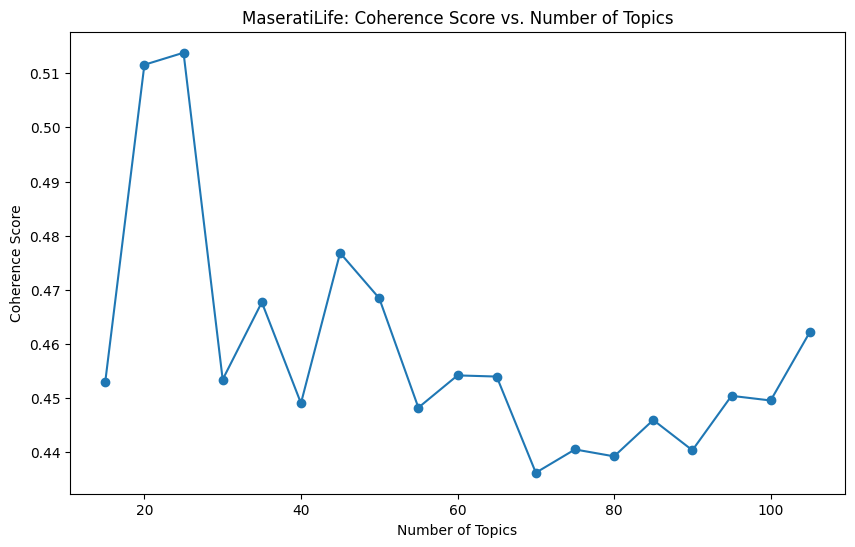

In [ ]:
# Plotting the coherence scores against the number of topics
num_topics_range = range(15, 110,5)
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_values[2:], marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score") 
plt.title("MaseratiLife: Coherence Score vs. Number of Topics")
plt.grid(False)
plt.show()


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=25,
                                           random_state=0,
                                           update_every=1,
                                           chunksize=700,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
#Compute Coherence Score:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence() #Higher the better
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.524873057440121


In [ ]:
#Visualize the topics:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.370994 -0.135537       1        1  26.578120
20     0.350973 -0.177795       2        1  23.301836
18     0.275213 -0.071765       3        1  13.644191
2      0.197684  0.206499       4        1   8.230033
1      0.141354  0.212264       5        1   6.119095
24     0.091401  0.273614       6        1   4.551329
0     -0.008270  0.082244       7        1   1.927186
3     -0.035015  0.015307       8        1   1.519103
8     -0.046093  0.002909       9        1   1.323576
4     -0.062093 -0.010258      10        1   1.114264
19    -0.059829 -0.008443      11        1   1.114102
22    -0.067738 -0.021086      12        1   0.988404
10    -0.066006 -0.019691      13        1   0.972563
21    -0.064268 -0.013444      14        1   0.946745
12    -0.070126 -0.025439      15        1   0.936400
14    -0.078380 -0.027157      16        1   0.887209
16    -0.072684 -0.023254      17        1   0.884232
7     -0.076144  0.014135      18        1   0.858374
13    -0.088214 -0.033490      19        1   0.787846
17    -0.086984 -0.032083      20        1   0.766928
9     -0.092771 -0.031027      21        1   0.697300
23    -0.101675 -0.039097      22        1   0.589945
6     -0.117327 -0.045790      23        1   0.432235
11    -0.116872 -0.046399      24        1   0.426777
5     -0.117132 -0.045219      25        1   0.402205, topic_info=           Term         Freq        Total Category  logprob  loglift
10       engine  1153.000000  1153.000000  Default  30.0000  30.0000
6           car  4764.000000  4764.000000  Default  29.0000  29.0000
303      dealer   951.000000   951.000000  Default  28.0000  28.0000
315    maserati  1581.000000  1581.000000  Default  27.0000  27.0000
22         part   811.000000   811.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
888   hilarious     0.695456     1.522846  Topic25  -6.8478   4.7322
1298      spelt     0.694148     1.521538  Topic25  -6.8497   4.7312
4058     define     0.024346     0.851736  Topic25 -10.2000   1.9611
3706     weight     0.024346     0.851737  Topic25 -10.2000   1.9611
55    basically     0.024388   111.460546  Topic25 -10.1983  -2.9114

[916 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0        18  0.969922           ab
1618     20  0.970400       accent
1744     15  0.972580     accident
2181     19  0.954835  accommodate
717       5  0.991836       accord
...     ...       ...          ...
2215     10  0.935831         wrap
430      22  0.995315        write
134       1  0.994897        wrong
479       2  0.998659         year
485      17  0.952205        yield

[1015 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 21, 19, 3, 2, 25, 1, 4, 9, 5, 20, 23, 11, 22, 13, 15, 17, 8, 14, 18, 10, 24, 7, 12, 6])